In [1]:
%load_ext autoreload
%autoreload 2

# Setup Paths

In [2]:
import os
import pyrootutils
root = pyrootutils.setup_root(
    search_from='.',
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)
hydra_cfg_path = root / "text_classification_problems" / "configs"
os.chdir(root / "text_classification_problems")

In [3]:
import hydra
from hydra import compose, initialize

from pathlib import Path
import numpy as np
import torch
from core.grads import tree_to_device
from core.tracer import KNN, KNNGD, KNNGN
from sklearn.neighbors import KNeighborsClassifier
from text_classification_problems.datamodule import TextClassifierDataModule
from text_classification_problems.modelmodule import TextClassifierModel
from transformers import AutoTokenizer
from tqdm import tqdm

import matplotlib.pyplot as plt

/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config  

In [4]:
'..' / hydra_cfg_path.relative_to(root)
with initialize(version_base=None, config_path= '../configs'):
    cfg = compose(config_name="tracing", return_hydra_config=True, overrides=["datamodule=snli", "tracer=gd"])

In [5]:
device = 'cuda:1'

# Load Data and Model

In [6]:
from datamodule import TextClassifierDataModule

In [7]:
checkpoint = torch.load("outputs/imdb/flip0.2_bert/121_2023-01-03_19-26-09/checkpoints/epoch=00_val_acc=0.8185.ckpt", map_location=device)
datamodule_hparams = checkpoint["datamodule_hyper_parameters"] 

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
dm = TextClassifierDataModule(
    data_root=os.environ["PYTORCH_DATASET_ROOT"],
    tokenizer=tokenizer,
    **datamodule_hparams,
    use_denoised_data=True
)
dm.prepare_data()
dm.setup("tracing")

In [9]:
net = hydra.utils.instantiate(cfg.net, num_classes=dm.num_classes)
lit_model = TextClassifierModel(
    net=net,
    num_classes=dm.num_classes,
    lr=1e-3,
)
lit_model.load_state_dict(checkpoint["state_dict"])
net = lit_model.net
lit_model.eval()
lit_model.to(device);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# np.savez_compressed('outputs/train/imdb/knn.npz', neibor_inds.numpy())

In [11]:
# neibor_inds = np.load('outputs/train/imdb/knn.npz')['arr_0']

## Tracing

In [12]:
from core.grads import RuntimeGradientExtractor
from core.tracer import GradientNormalize as GN, GradientCosin as GC, GradientBasedTracer as GD
import torch.nn.functional as F
from text_classification_problems.run_tracing import register_BatchEncoding
import pandas as pd
from core.aggregation import aggregation
from core.eval import eval
from core.aggregation import cal_neibor_matrices

In [13]:
register_BatchEncoding()

## Comparation

In [14]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
def loss_fn(pred_fn, batch):
    labels = batch["label"]
    preds = pred_fn(batch)
    return F.cross_entropy(preds, labels)
def eval_ckpt(ckpt):
    ckpt = torch.load(ckpt, map_location=device)
    datamodule_hparams = ckpt["datamodule_hyper_parameters"] 
    datamodule_hparams["train_batch_size"] = 256
    
    dm = TextClassifierDataModule(
        data_root=os.environ["PYTORCH_DATASET_ROOT"],
        tokenizer=tokenizer,
        **datamodule_hparams,
        use_denoised_data=False
    )
    dm.prepare_data()
    dm.setup("tracing")

    lit_model.load_state_dict(checkpoint["state_dict"])
    
    grad_extractor = RuntimeGradientExtractor(
        lit_model,
        split_params=lambda params: (params[:-2], params[-2:]),
        merge_params=lambda w1, w2: w1 + w2,
        loss_fn=loss_fn,
        input_sample=next(iter(dm.trace_dataloader())),
    )
    neibor_inds = cal_neibor_matrices(
        lit_model,
        ref_loader=dm.train_dataloader(shuffle=False),
        trace_loader=dm.trace_dataloader(),
        device=device,
        k=1000,
        is_self_ref=True
    )
    result_df = eval(
        dm,
        lit_model,
        grad_extractor,
        label_from_batch=lambda b: b["label"],
        neighbor_matrices=neibor_inds,
        colected_ks=list(range(50, 1000, 10)),
    )
    return result_df

In [15]:
result_df = eval_ckpt("outputs/imdb/flip0.2_bert/121_2023-01-03_19-26-09/checkpoints/epoch=01_val_acc=0.8348.ckpt")

{'token_type_ids': torch.Size([256, 128]), 'label': torch.Size([256]), 'input_ids': torch.Size([256, 128]), 'attention_mask': torch.Size([256, 128])}
[torch.Size([256, 128]), torch.Size([256]), torch.Size([256, 128]), torch.Size([256, 128])]


100%|██████████| 69/69 [01:49<00:00,  1.59s/it]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  3.21it/s]
Loop KNN GD: 100%|██████████| 1000/1000 [00:41<00:00, 24.31it/s]


In [19]:
result_df.sort_values(by="top50", ascending=False).head(20)

,method,top50,top100,top150,top200,top250,top300,top350,top400,top450,...,top850,top900,top950,top1000,top1050,top1100,top1150,top1200,top1250,top1300
72,KNN_210,100.0,100.000000,99.333334,99.500000,99.199998,98.000002,97.714287,97.250003,97.333336,...,95.411766,94.666666,93.789476,93.300003,92.952383,92.454547,91.913044,91.916668,91.600001,91.384614
272,KNN_710,100.0,100.000000,98.666668,99.000001,99.199998,98.666668,97.714287,97.000003,96.888888,...,94.823527,94.555557,94.105262,93.400002,92.952383,92.636365,92.173910,92.083335,91.520000,91.153848
184,KNN_490,100.0,100.000000,99.333334,98.500001,98.799998,98.000002,97.714287,97.750002,96.666664,...,94.823527,94.666666,94.105262,93.699998,93.333334,93.000001,92.173910,91.916668,91.680002,91.538459
268,KNN_700,100.0,99.000001,99.333334,99.000001,99.199998,98.333335,98.000002,96.749997,96.888888,...,94.941175,94.555557,94.315791,93.199998,92.857140,92.363638,92.173910,91.916668,91.520000,91.153848
188,KNN_500,100.0,100.000000,98.666668,99.000001,98.799998,98.000002,98.000002,97.250003,96.666664,...,94.705880,94.666666,93.894738,93.699998,93.238097,92.818183,92.173910,91.916668,91.920000,91.461539
76,KNN_220,100.0,99.000001,99.333334,99.500000,98.799998,98.333335,97.714287,97.500002,96.888888,...,95.294118,94.444442,94.315791,93.900001,93.333334,92.636365,92.260867,91.833335,91.680002,91.461539
192,KNN_510,100.0,100.000000,100.000000,99.500000,98.799998,98.333335,97.714287,97.500002,97.111112,...,94.588238,94.222224,94.000000,93.500000,93.333334,92.727274,92.173910,92.083335,91.839999,91.769230
296,KNN_770,100.0,99.000001,98.666668,99.000001,98.799998,98.333335,98.000002,97.250003,97.111112,...,94.941175,94.333333,93.894738,93.300003,92.857140,92.636365,92.260867,91.583335,91.360003,91.076922
264,KNN_690,100.0,99.000001,98.666668,99.000001,99.199998,98.333335,98.000002,97.250003,96.888888,...,94.941175,94.777775,94.000000,93.400002,92.952383,92.363638,92.260867,91.833335,91.600001,91.307694
196,KNN_520,100.0,100.000000,100.000000,99.000001,99.199998,98.000002,97.714287,97.500002,96.888888,...,94.588238,94.000000,94.000000,93.699998,93.238097,92.909092,92.260867,91.916668,91.759998,91.615385


In [69]:
result_df.sort_values(by="top100", ascending=False).head(20)

,method,top50,top100,top150,top200,top250,top300,top350,top400,top450,...,top850,top900,top950,top1000,top1050,top1100,top1150,top1200,top1250,top1300
152,KNN_410,89.999998,87.000000,83.333331,81.500000,80.800003,78.333336,75.999999,74.500000,74.222225,...,65.647060,65.111113,64.105260,63.200003,62.285715,61.272728,60.173911,58.583331,57.279998,55.692309
252,KNN_660,88.000000,87.000000,83.333331,80.500001,80.000001,77.666664,75.714284,74.500000,74.222225,...,65.647060,65.444446,64.210528,63.000000,62.285715,61.181819,60.000002,58.666664,57.120001,55.615383
44,KNN_140,83.999997,87.000000,83.333331,81.999999,80.800003,77.666664,75.999999,74.500000,73.777777,...,65.529412,64.666665,63.789475,63.099998,62.476188,61.363637,59.913045,58.666664,56.879997,55.692309
4,SA_GN,83.999997,87.000000,82.666665,82.499999,79.200000,75.666666,75.428569,75.000000,73.333335,...,55.764705,55.222225,55.368423,54.799998,54.571426,54.727274,54.608697,54.916668,55.199999,55.230767
5,SC_GN,83.999997,87.000000,84.666669,81.999999,79.600000,77.333331,74.571431,75.500000,72.666669,...,65.764707,65.222222,64.631581,63.700002,62.666667,61.181819,59.913045,58.666664,57.359999,55.692309
276,KNN_720,88.000000,87.000000,83.333331,80.500001,80.400002,77.666664,75.999999,74.750000,74.000001,...,65.411764,65.111113,63.999999,63.200003,62.190479,61.181819,59.826088,58.666664,57.200003,55.692309
280,KNN_730,88.000000,87.000000,83.999997,80.000001,80.400002,77.666664,75.999999,74.750000,74.000001,...,65.529412,65.222222,64.105260,63.099998,62.095237,61.181819,59.913045,58.749998,57.200003,55.538464
272,KNN_710,88.000000,86.000001,83.333331,80.000001,80.000001,77.999997,75.999999,74.500000,74.222225,...,65.411764,65.222222,63.999999,63.200003,62.190479,61.363637,59.913045,58.666664,57.200003,55.538464
72,KNN_210,88.000000,86.000001,81.333333,82.499999,80.400002,77.999997,75.714284,74.750000,74.222225,...,66.000003,64.888889,63.578945,63.200003,62.190479,61.272728,60.260868,58.916664,57.120001,55.538464
68,KNN_200,86.000001,86.000001,82.666665,81.999999,80.800003,78.333336,75.714284,74.250001,74.222225,...,66.000003,64.777780,63.789475,63.099998,62.190479,61.090910,60.173911,58.666664,57.200003,55.769229


In [70]:
result_df.sort_values(by="top300", ascending=False).head(10)

,method,top50,top100,top150,top200,top250,top300,top350,top400,top450,...,top850,top900,top950,top1000,top1050,top1100,top1150,top1200,top1250,top1300
28,KNN_100,86.000001,81.000000,81.333333,81.500000,79.600000,78.666669,76.285714,74.750000,74.222225,...,65.647060,64.333332,63.999999,63.200003,62.761903,61.636364,59.826088,58.499998,57.120001,55.692309
164,KNN_440,89.999998,85.000002,82.666665,81.500000,80.400002,78.333336,75.714284,74.750000,74.000001,...,65.764707,65.111113,64.315790,63.099998,62.571430,61.181819,60.000002,58.666664,57.200003,55.538464
3,SC_GD,75.999999,77.999997,79.333335,80.000001,78.799999,78.333336,74.571431,74.250001,73.111111,...,65.647060,65.333331,64.315790,63.599998,62.761903,61.090910,59.826088,58.583331,57.359999,55.692309
52,KNN_160,86.000001,85.000002,83.999997,82.499999,81.599998,78.333336,75.714284,74.750000,74.000001,...,65.882355,64.777780,63.999999,63.599998,62.476188,61.363637,60.000002,58.666664,56.879997,55.538464
152,KNN_410,89.999998,87.000000,83.333331,81.500000,80.800003,78.333336,75.999999,74.500000,74.222225,...,65.647060,65.111113,64.105260,63.200003,62.285715,61.272728,60.173911,58.583331,57.279998,55.692309
64,KNN_190,86.000001,86.000001,82.666665,81.999999,81.199998,78.333336,75.714284,74.000001,74.222225,...,65.882355,64.999998,63.894737,63.200003,62.476188,61.363637,60.434783,58.999997,57.200003,55.615383
32,KNN_110,83.999997,83.999997,81.999999,81.999999,80.400002,78.333336,76.285714,74.750000,74.000001,...,65.411764,64.555556,64.210528,62.900001,62.380952,61.636364,60.260868,58.499998,57.200003,55.538464
68,KNN_200,86.000001,86.000001,82.666665,81.999999,80.800003,78.333336,75.714284,74.250001,74.222225,...,66.000003,64.777780,63.789475,63.099998,62.190479,61.090910,60.173911,58.666664,57.200003,55.769229
36,KNN_120,83.999997,85.000002,83.333331,81.500000,80.800003,77.999997,76.285714,74.750000,74.000001,...,65.764707,64.888889,64.210528,63.000000,62.571430,61.636364,60.521740,58.583331,56.879997,55.538464
124,KNN_340,88.000000,85.000002,82.666665,81.999999,80.800003,77.999997,75.714284,74.750000,74.000001,...,65.411764,65.555555,64.105260,63.300002,62.285715,61.181819,60.260868,58.833331,57.200003,55.538464


In [26]:
sel_sizes = range(50, 1310, 50)

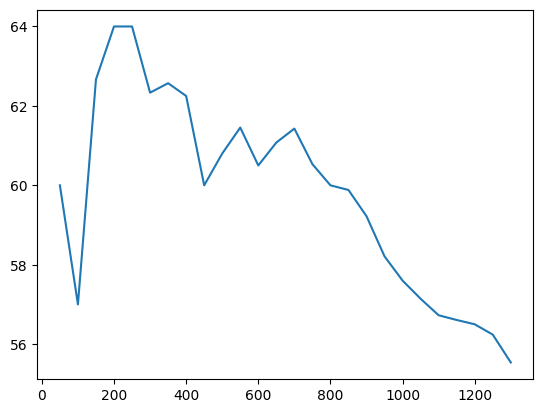

In [43]:
# plt.plot(sel_sizes, result_df[result_df["method"] == "KNN_10"].values[0, 1:])
# plt.plot(sel_sizes, result_df[result_df["method"] == "KNN_30"].values[0, 1:])
plt.plot(sel_sizes, result_df[result_df["method"] == "KNN_50"].values[0, 1:])


In [107]:
GN = pd.concat((
    result_df[result_df["method"] == "SA_GN"].iloc[0],
    result_df[result_df["method"] == "SC_GN"].iloc[0],
),
    axis=1
).T
GN = pd.concat(
    (GN,
        result_df[result_df["method"].str.contains("KNN_GN")].sort_values(by="top100", ascending=False),),
    axis=0
)

In [108]:
GN

,method,top50,top100,top150,top200,top250,top300,top350,top400,top450,...,top850,top900,top950,top1000,top1050,top1100,top1150,top1200,top1250,top1300
4,SA_GN,83.999997,87.0,82.666665,82.499999,79.2,75.666666,75.428569,75.0,73.333335,...,55.764705,55.222225,55.368423,54.799998,54.571426,54.727274,54.608697,54.916668,55.199999,55.230767
5,SC_GN,83.999997,87.0,84.666669,81.999999,79.6,77.333331,74.571431,75.5,72.666669,...,65.764707,65.222222,64.631581,63.700002,62.666667,61.181819,59.913045,58.666664,57.359999,55.692309
78,KNN_GN_220,81.999999,86.000001,81.333333,78.500003,77.600002,74.666667,73.428571,72.250003,69.999999,...,53.176469,53.444445,53.263158,52.999997,52.857143,53.27273,53.30435,54.000002,54.320002,55.076921
74,KNN_GN_210,81.999999,85.000002,81.999999,79.500002,77.600002,75.0,74.285716,71.499997,69.555557,...,53.058821,53.222221,52.947366,52.8,52.666664,52.999997,53.217393,53.916669,54.479998,55.076921
322,KNN_GN_830,81.999999,85.000002,82.666665,81.5,77.999997,76.666665,74.285716,73.000002,71.333331,...,54.000002,53.666669,53.894734,53.799999,53.428572,53.727275,53.652173,54.000002,54.640001,55.076921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,KNN_GN_100,83.999997,81.0,80.000001,76.999998,75.999999,74.333334,72.857141,71.499997,68.000001,...,52.470589,52.555555,52.210528,52.3,52.285713,52.545452,52.956522,53.666669,54.24,55.076921
22,KNN_GN_80,83.999997,81.0,80.000001,76.499999,74.800003,74.666667,72.000003,70.249999,68.000001,...,52.352941,52.444446,52.315789,52.200001,52.09524,52.454543,52.782607,53.333336,54.000002,55.000001
14,KNN_GN_60,83.999997,81.0,78.666669,77.499998,74.800003,74.000001,72.285712,70.999998,68.666667,...,52.588236,52.333331,52.315789,52.200001,52.285713,52.636361,53.130436,53.916669,54.079998,55.000001
10,KNN_GN_50,83.999997,81.0,81.333333,77.499998,74.400002,74.000001,73.428571,70.999998,68.222225,...,52.588236,52.444446,52.210528,52.499998,52.761906,52.545452,53.043479,53.666669,53.839999,55.000001


In [109]:
imdb_real_train_path = Path("outputs/imdb/flip0_bert/")
for ckpt in imdb_real_train_path.rglob("checkpoints/epoch=*.ckpt"):
    print(ckpt)
    result_df = eval_ckpt(ckpt)
    result_df.to_csv(str(ckpt)+".csv")

outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=00_val_acc=0.8616.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.33it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 584.83it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=01_val_acc=0.8531.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.53it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 636.42it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=02_val_acc=0.8799.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.39it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 598.76it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=03_val_acc=0.8812.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.53it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 618.67it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=04_val_acc=0.8716.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.63it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 595.44it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=05_val_acc=0.8744.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.39it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 590.49it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=06_val_acc=0.8788.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.78it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 635.21it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=07_val_acc=0.8775.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.41it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 636.67it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=08_val_acc=0.8824.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.39it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 607.83it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=09_val_acc=0.8831.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.46it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 620.24it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=00_val_acc=0.8723.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.14it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 628.63it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=01_val_acc=0.8777.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.30it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 628.94it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=02_val_acc=0.8753.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.25it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 611.59it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=03_val_acc=0.8779.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.55it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 634.97it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=04_val_acc=0.8836.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.65it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 612.14it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=05_val_acc=0.8793.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.71it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 578.14it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=06_val_acc=0.8720.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.77it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 604.23it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=07_val_acc=0.8796.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.24it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 602.83it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=08_val_acc=0.8813.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.43it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 606.49it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=09_val_acc=0.8811.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.27it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 604.37it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=00_val_acc=0.8711.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.24it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.59it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 598.23it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=01_val_acc=0.8775.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.52it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 625.77it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=02_val_acc=0.8777.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.58it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 635.34it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=03_val_acc=0.8869.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.35it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 642.02it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=04_val_acc=0.8829.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.39it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 639.47it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=05_val_acc=0.8776.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.38it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 614.80it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=06_val_acc=0.8795.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.48it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 613.57it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=07_val_acc=0.8728.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.69it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 637.60it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=08_val_acc=0.8689.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.13it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 632.14it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=09_val_acc=0.8781.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.24it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.42it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 652.11it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=00_val_acc=0.8719.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.30it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 674.91it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=01_val_acc=0.8803.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.59it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 640.19it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=02_val_acc=0.8765.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.29it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 650.56it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=03_val_acc=0.8801.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.36it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 630.32it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=04_val_acc=0.8656.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.48it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 645.12it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=05_val_acc=0.8733.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.42it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 650.99it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=06_val_acc=0.8763.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.46it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 640.40it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=07_val_acc=0.8732.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.46it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 622.12it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=08_val_acc=0.8788.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.23it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 628.77it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=09_val_acc=0.8783.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.35it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 628.32it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=00_val_acc=0.8709.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.44it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 628.72it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=01_val_acc=0.8592.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.34it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 657.51it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=02_val_acc=0.8791.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.66it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 652.98it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=03_val_acc=0.8764.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.39it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 629.92it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=04_val_acc=0.8707.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.54it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 626.57it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=05_val_acc=0.8769.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.58it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 667.74it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=06_val_acc=0.8796.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.20it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 682.02it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=07_val_acc=0.8708.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  4.93it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 688.08it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=08_val_acc=0.8792.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.50it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 662.58it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=09_val_acc=0.8811.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:00,  5.76it/s]
Loop KNN GD: 100%|██████████| 1001/1001 [00:01<00:00, 677.59it/s]
